In [11]:
import xarray as xr
import numpy as np
import scipy as sp
import seastar as ss
import warnings
import os
from _version import __version__

In [3]:
save_folder=os.path.join('D:\data\SEASTAR\SEASTARex\Data\L1c','')
#days = ['17','22','25','26']
days = ['17', '22', '25', '26']
flights = ['202205' + d for d in days]
file_paths = ss.utils.readers._set_file_paths()
file_paths['l1b_path'] = "D:\\data\\SEASTAR\\SEASTARex\\Data\\L1b\\"
L1b_path = os.path.join(file_paths['l1b_path'],'')
DAR_tracks = dict()
DAR_tracks['20220517'] = {
    'Track_11': 0,
    'Track_12': 1,
    'Track_13': 2,
    'Track_2': 3,
    'Track_1': 4,
    'Track_1b': 5,
    'Track_L1': 6,
}
DAR_tracks['20220522'] = {
    'Track_1': 0,
    'Track_2': 1,
    'Track_1b': 2,
    'Track_11': 3,
    'Track_12': 4,
    'Track_13': 5,
    'Track_14': 6,
    'Track_15': 7,
    'Track_16': 8,
    'Track_17': 9,
    'Track_18': 10,
    'Track_2b': 11,
    'Track_L1': 12,
}
DAR_tracks['20220525'] = {
    'Track_L1': 0,
    'Track_22a1': 1,
    'Track_22a2': 2,
    'Track_22a3': 3,
    'Track_22a4': 4,
    'Track_22a5': 5,
    'Track_22b': 6,
}
DAR_tracks['20220526'] = {
    'Track_2': 0,
    'Track_1': 1,
    'Track_13': 2,
    'Track_14': 3,
    'Track_11': 4,
    'Track_12': 5,
    'Track_17': 6,
    'Track_18': 7,
    'Track_15': 8,
    'Track_16': 9,
    'Track_2b': 10,
    'Track_1b': 11,
    'Track_L1': 12,
}

Device name = LIVPCZG-10
Setting local paths...


In [10]:
flight='20220517'
DAR_list=DAR_tracks[flight]
track='Track_1'
ds_L1b = xr.open_dataset(file_paths['l1b_path'] + flight + '_' + track + '_OSCAR_L1b.nc')
sigma0_bias = xr.open_dataset('D:\\data\\SEASTAR\\SEASTARex\\Data\\calib\\sigma0_bias.nc')
def fit_func_simple(az, A, B, C, f):
    g = A * (
            1\
            + np.sign(A)*B*np.cos(np.radians(az-f))\
            + np.sign(A)*C*np.cos(np.radians(2*(az-f)))
        )
    return(g.ravel())

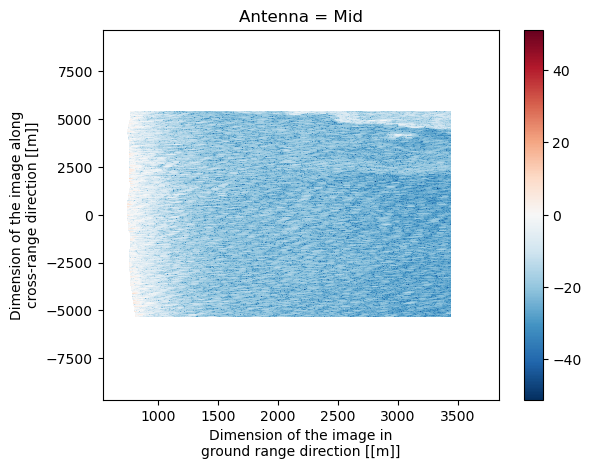

In [61]:

Sigma0 = [ds_L1b.Intensity.sel(Antenna=ant) \
/ np.reshape(ss.utils.tools.db2lin(
    fit_func_simple(ds_L1b.IncidenceAngleImage.sel(Antenna=ant).data,
                        *sigma0_bias.bias.sel(Antenna=ant).data,
                       )),ds_L1b.Intensity.sel(Antenna=ant).shape
            ) for ant in ds_L1b.Antenna]
ds_L1b['Sigma0'] = xr.concat(Sigma0, dim='Antenna')
ds_L1b['Sigma0'].attrs['long_name'] = 'Sigma0'
ds_L1b['Sigma0'].attrs['units'] = ''
ds_L1b['Sigma0'].attrs['description'] = 'Calibrated NESZ using NSCAT4DS and over-ocean OSCAR data'
ss.utils.tools.lin2db(ds_L1b.Sigma0.sel(Antenna='Mid')*np.sin(np.radians(ds_L1b.sel(Antenna='Mid').IncidenceAngleImage))).plot()

In [62]:
for flight in flights:
    print('Processing flight ', flight, '...')
    DAR_list=DAR_tracks[flight]
    for track in DAR_list.keys():
        print('Processing track',track,'...')
        ds_L1b = xr.open_dataset(file_paths['l1b_path'] + flight + '_' + track + '_OSCAR_L1b.nc')
        ds_L1c = ds_L1b.copy(deep=True)
        Sigma0 = [ds_L1b.Intensity.sel(Antenna=ant) \
                / np.reshape(ss.utils.tools.db2lin(
            fit_func_simple(ds_L1b.IncidenceAngleImage.sel(Antenna=ant).data,
                        *sigma0_bias.bias.sel(Antenna=ant).data,
                       )),ds_L1b.Intensity.sel(Antenna=ant).shape
                            ) for ant in ds_L1b.Antenna]
        ds_L1c['Sigma0'] = xr.concat(Sigma0, dim='Antenna')
        ds_L1c['Sigma0'].attrs['long_name'] = 'Sigma0'
        ds_L1c['Sigma0'].attrs['units'] = ''
        ds_L1c['Sigma0'].attrs['description'] = 'Calibrated NESZ using NSCAT4DS and over-ocean OSCAR data'
#         ds_L1c['Interferogram'].loc[dict({'Antenna': 'Fore'})] = ds_L1b.sel(Antenna='Fore').Interferogram\
#                     - -0.0025 * ds_L1b.sel(Antenna='Fore').IncidenceAngleImage - 0.129
#         ds_L1c['Interferogram'].loc[dict({'Antenna': 'Aft'})] = ds_L1b.sel(Antenna='Aft').Interferogram\
#                     - 0.0043 * ds_L1b.sel(Antenna='Aft').IncidenceAngleImage - -0.2364
        
#         ds_L1c.attrs['Interferogram corrected for Sigma0'] = {'function': 'y = m * x + c',
#                                                   'Fore': 'm = -0.0025, c = 0.129',
#                                          'Aft': 'm = -0.0043, c = -0.2364'}
        rsv = [ss.oscar.level1.compute_radial_surface_velocity(ds_L1c.sel(Antenna=ant))
               for ant in ds_L1c.Antenna.values]
        ds_L1c['RadialSurfaceVelocity'] = xr.concat(rsv, 'Antenna',join='outer')
        print('Saving to disk...')
        ds_L1c.to_netcdf(os.path.join(save_folder, flight + '_' + track +'_OSCAR_L1c.nc'))

Processing flight  20220517 ...
Processing track Track_11 ...
Saving to disk...
Processing track Track_12 ...
Saving to disk...
Processing track Track_13 ...
Saving to disk...
Processing track Track_2 ...
Saving to disk...
Processing track Track_1 ...
Saving to disk...
Processing track Track_1b ...
Saving to disk...
Processing track Track_L1 ...
Saving to disk...
Processing flight  20220522 ...
Processing track Track_1 ...
Saving to disk...
Processing track Track_2 ...
Saving to disk...
Processing track Track_1b ...
Saving to disk...
Processing track Track_11 ...
Saving to disk...
Processing track Track_12 ...
Saving to disk...
Processing track Track_13 ...
Saving to disk...
Processing track Track_14 ...
Saving to disk...
Processing track Track_15 ...
Saving to disk...
Processing track Track_16 ...
Saving to disk...
Processing track Track_17 ...
Saving to disk...
Processing track Track_18 ...
Saving to disk...
Processing track Track_2b ...
Saving to disk...
Processing track Track_L1 ..